In [28]:
import healpy as hp

In [29]:
from simulation import ExpMaps
import matplotlib.pyplot as plt
import basic
import curvedsky as cs
import cmb
import numpy as np
from utils import camb_clfile

In [3]:
#Tcmb  = 2.726e6  
Tcmb  = 2.726e6
nside = 512        
lmax  = 2*nside     
npix  = 12*nside**2
l = np.linspace(0,lmax,lmax+1)
lfac = l*(l+1)/2/np.pi

sigma = 2.16      
Nl = (sigma*(np.pi/10800.)/Tcmb)**2 * np.ones(lmax+1)
#Nl = (sigma*(np.pi/10800.)/1e6)**2 * np.ones(lmax+1)

Lmax  = 1024      # maximum multipole of output normalization
rlmin, rlmax = 200, 1024  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/(2*np.pi)

In [4]:
sim_dir = '/global/cscratch1/sd/lonappan/S4BIRD/LiteBIRD/SIM_SET1/Maps'

In [5]:
cl = cmb.read_camb_cls("/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat",ftype='lens',output='array')[:,:lmax+1]

In [6]:
cl_len = camb_clfile("/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat")
cl_unl = camb_clfile("/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lenspotential.dat")

In [7]:
mask_full = hp.read_map("/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits.gz")

In [8]:
sim = ExpMaps(sim_dir,30,lmax)

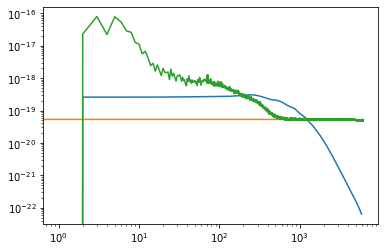

In [47]:
plt.loglog(cl_len['bb']/Tcmb**2)
plt.loglog(Nl)
#plt.axhline(np.radians(2.16/60)**2/Tcmb**2)
plt.loglog(hp.alm2cl(sim.get_sim_blm(0))/.8)

In [10]:
mask = hp.ud_grade(mask_full,nside)

In [11]:
bl = 1./cmb.beam(30.,lmax)
Bl = np.reshape(bl,(1,lmax+1))

In [30]:
invn = mask * (sigma*(np.pi/10800.)/Tcmb)**(-2)
invN = np.reshape(np.array((invn,invn)),(2,1,npix))

In [31]:
Talm, Ealm, Balm = cs.utils.gaussTEB(rlmax,cl[0,:],cl[1,:],cl[2,:],cl[3,:])

In [32]:
TALM = sim.get_sim_tlm(0)

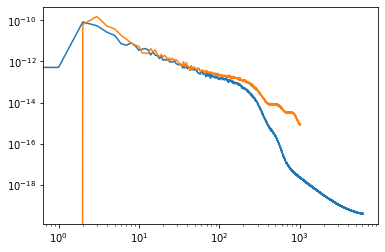

In [33]:
plt.loglog(hp.alm2cl(TALM))
plt.loglog(cs.utils.alm2cl(lmax,Talm))

In [34]:
omap = {}
_, omap['Q'], omap['U'] = hp.alm2map([sim.get_sim_tlm(0),sim.get_sim_elm(0),sim.get_sim_blm(0)],nside)

In [42]:
QU = np.reshape(np.array((omap['Q'],omap['U'])),(2,1,npix)) # restrict T, Q, U to observed area
ilm = {}
ilm['E'], ilm['B'] = cs.cninv.cnfilter_freq(2,1,nside,lmax,cl[1:3,:],Bl,invN,QU,chn=1,itns=[1000],eps=[1e-5],filter='',ro=10,stat='status.txt')

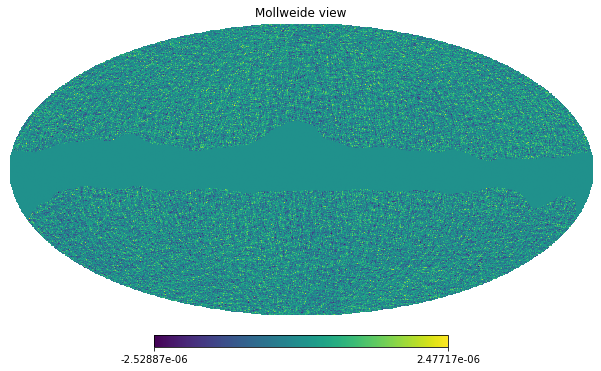

In [44]:
hp.mollview(omap['Q'])

/tmp/ipykernel_62065/1043594268.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl[2:3,:][0])


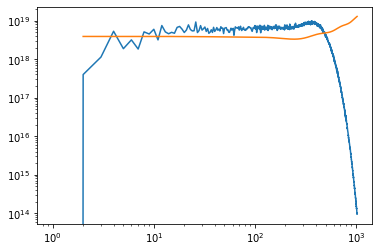

In [45]:
#plmollview(hp.alm2cl(sim.get_sim_blm(0)))
plt.loglog(cs.utils.alm2cl(lmax,ilm['B']))
plt.loglog(1/cl[2:3,:][0])
#plt.axhline(np.radians(2.16/60)**2)

In [19]:
lcl = cl.copy()

In [20]:
ocl = lcl.copy()
ocl[1,:]  += Nl/bl**2
ocl[2,:]  += Nl/bl**2

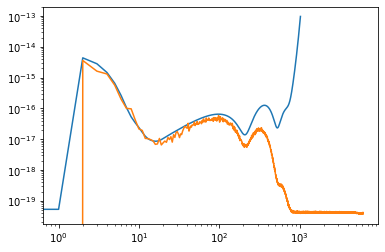

In [21]:
plt.loglog(ocl[1,:])
plt.loglog(hp.alm2cl(sim.get_sim_elm(0)))

In [22]:
Ag, Ac = {}, {}
Ag['EB'], Ac['EB'] = cs.norm_quad.qeb('lens',Lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])

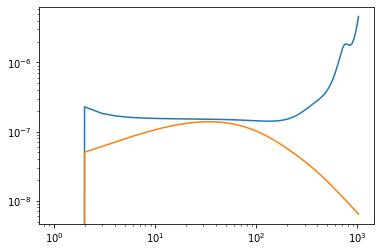

In [23]:
plt.loglog(L,Lfac*Ag['EB'])
plt.loglog(L,Lfac*cl_unl['pp'][:len(L)])

In [24]:
glm, clm = {}, {}
glm['EB'], clm['EB'] = cs.rec_lens.qeb(Lmax,rlmin,rlmax,lcl[1,:],ilm['E'], ilm['B'])

In [25]:
glm['EB'] *= Ag['EB'][:,None]
clm['EB'] *= Ac['EB'][:,None]

In [26]:
gg, cc = {}, {}
gg['eb'] = cs.utils.alm2cl(Lmax,glm['EB'])
cc['eb'] = cs.utils.alm2cl(Lmax,clm['EB'])


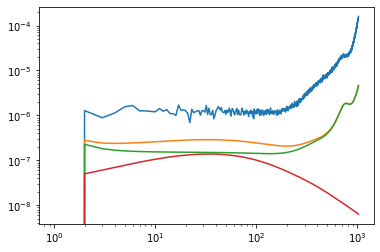

In [53]:
plt.loglog(Lfac*gg['eb']/.8)
plt.loglog(Lfac*(cl_unl['pp'][:len(L)]+Ag['EB']))
plt.loglog(Lfac*(Ag['EB']))
plt.loglog(Lfac*cl_unl['pp'][:len(L)])